# ЛР3 — Классификация оттока клиентов (Credit Card Customers)
Данные: `data/raw/BankChurners.csv`

## 0. Постановка задачи
Предсказать `Attrition_Flag` (Attrited/Existing Customer) по признакам клиента.
Это задача **бинарной классификации**.

In [3]:
from pathlib import Path

PROJECT_ROOT = Path('..').resolve()
DATA_PATH = PROJECT_ROOT/'data'/'raw'/'BankChurners.csv'
PROJECT_ROOT, DATA_PATH

(PosixPath('/home/decll/Документы/ML-HW/HW3&7'),
 PosixPath('/home/decll/Документы/ML-HW/HW3&7/data/raw/BankChurners.csv'))

## 1. Чтение данных

In [4]:
import pandas as pd

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Не найден файл {DATA_PATH}. Скачайте датасет с Kaggle и положите BankChurners.csv в data/raw/"
    )

df_raw = pd.read_csv(DATA_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Очистка: удаляем ID (`CLIENTNUM`) и служебные колонки Naive Bayes (если есть).

In [5]:
df = df_raw.copy()

df = df.drop(columns=["CLIENTNUM"], errors="ignore")
nb_cols = [c for c in df.columns if c.startswith("Naive_Bayes_Classifier") or "Naive_Bayes" in c]
if nb_cols:
    df = df.drop(columns=nb_cols, errors="ignore")

print("Clean shape:", df.shape)
df.head()

Clean shape: (10127, 20)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## 2. Разбиение на обучающую и тестовую выборки

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

TARGET = "Attrition_Flag"
X = df.drop(columns=[TARGET])
y = df[TARGET]

# FIX: кодируем строковые метки в числа (устраняет ошибки kNN/скоринга)
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

X_train.shape, X_test.shape

((8101, 19), (2026, 19))

## 3. EDA: характеристики, распределения, корреляции

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# распределение целевого (в исходных строках)
class_dist = y.value_counts().to_frame("count")
class_dist["share"] = class_dist["count"] / class_dist["count"].sum()
class_dist

,count,share
Attrition_Flag,,
Existing Customer,8500,0.83934
Attrited Customer,1627,0.16066


In [8]:
# базовые статистики по числовым
num = df.select_dtypes(include=["number"])
num.describe().T.head(20)

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


In [9]:
# корреляции
if num.shape[1] > 1:
    corr = num.corr()
    display(corr.iloc[:10, :10])
else:
    corr = None
    corr

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1
Customer_Age,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042
Dependent_count,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439
Months_on_book,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959
Total_Relationship_Count,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119
Months_Inactive_12_mon,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247
Contacts_Count_12_mon,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445
Credit_Limit,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813
Total_Revolving_Bal,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174
Avg_Open_To_Buy,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595
Total_Amt_Chng_Q4_Q1,-0.062042,-0.035439,-0.048959,0.050119,-0.032247,-0.024445,0.012813,0.058174,0.007595,1.000000


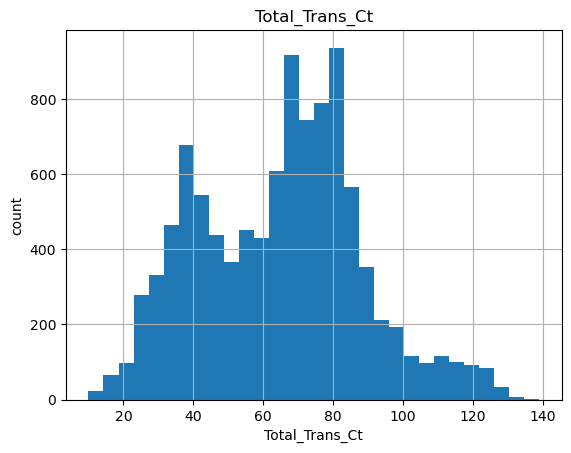

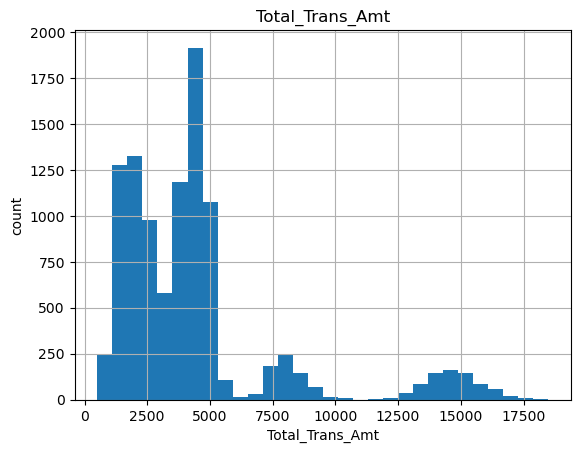

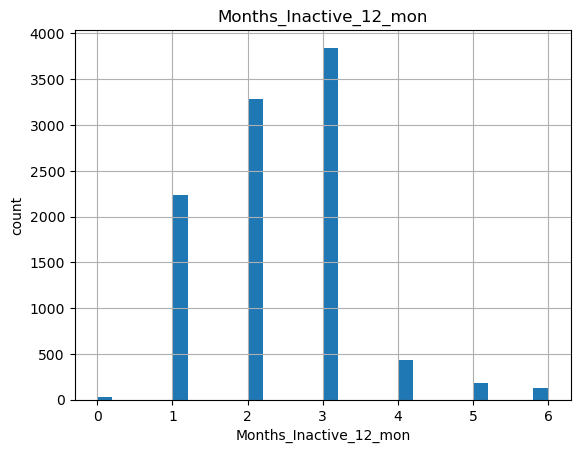

In [ ]:
for col in ["Total_Trans_Ct", "Total_Trans_Amt", "Months_Inactive_12_mon"]:
    if col in df.columns:
        plt.figure()
        df[col].hist(bins=30)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()

## 4. Пропущенные значения

In [9]:
miss = (df.isna().sum()
          .to_frame(name="missing_count")
          .assign(missing_pct=lambda x: 100 * x["missing_count"] / len(df))
          .reset_index()
          .rename(columns={"index": "column"})
          .sort_values("missing_count", ascending=False))
miss.head(30)

,column,missing_count,missing_pct
0,Attrition_Flag,0,0.0
1,Customer_Age,0,0.0
2,Gender,0,0.0
3,Dependent_count,0,0.0
4,Education_Level,0,0.0
5,Marital_Status,0,0.0
6,Income_Category,0,0.0
7,Card_Category,0,0.0
8,Months_on_book,0,0.0
9,Total_Relationship_Count,0,0.0


## 5–6. Категориальные признаки + нормализация
Для **kNN нормализация нужна**, иначе признаки с большим масштабом доминируют.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

(cat_cols[:5], len(cat_cols), len(num_cols))

(['Gender',
  'Education_Level',
  'Marital_Status',
  'Income_Category',
  'Card_Category'],
 5,
 14)

## 7. Запуск классификатора: baseline и kNN + подбор k

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

baseline = Pipeline([
    ("prep", preprocessor),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)
print("Baseline confusion matrix:")
print(confusion_matrix(y_test, y_pred_base))
print("\nBaseline report (labels decoded):")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_base), zero_division=0))

Baseline confusion matrix:
[[   0  325]
 [   0 1701]]

Baseline report (labels decoded):
                   precision    recall  f1-score   support

Attrited Customer       0.00      0.00      0.00       325
Existing Customer       0.84      1.00      0.91      1701

         accuracy                           0.84      2026
        macro avg       0.42      0.50      0.46      2026
     weighted avg       0.70      0.84      0.77      2026



In [12]:
knn_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", KNeighborsClassifier())
])

param_grid = {
    "clf__n_neighbors": list(range(1, 51)),
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]  # Manhattan/Euclidean
}

gs = GridSearchCV(knn_pipe, param_grid=param_grid, scoring="f1_macro", cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV f1_macro:", gs.best_score_)

Best params: {'clf__n_neighbors': 6, 'clf__p': 1, 'clf__weights': 'uniform'}
Best CV f1_macro: 0.821618715152554


## 8. Ошибки на train/test, матрицы рассогласования и комментарии

In [13]:
best_model = gs.best_estimator_

for split_name, X_split, y_split in [("TRAIN", X_train, y_train), ("TEST", X_test, y_test)]:
    pred = best_model.predict(X_split)
    print("\n===", split_name, "===")
    print("Confusion matrix:")
    print(confusion_matrix(y_split, pred))
    print("\nReport (labels decoded):")
    print(classification_report(le.inverse_transform(y_split), le.inverse_transform(pred), zero_division=0))


=== TRAIN ===
Confusion matrix:
[[ 954  348]
 [ 149 6650]]

Report (labels decoded):
                   precision    recall  f1-score   support

Attrited Customer       0.86      0.73      0.79      1302
Existing Customer       0.95      0.98      0.96      6799

         accuracy                           0.94      8101
        macro avg       0.91      0.86      0.88      8101
     weighted avg       0.94      0.94      0.94      8101


=== TEST ===
Confusion matrix:
[[ 205  120]
 [  63 1638]]

Report (labels decoded):
                   precision    recall  f1-score   support

Attrited Customer       0.76      0.63      0.69       325
Existing Customer       0.93      0.96      0.95      1701

         accuracy                           0.91      2026
        macro avg       0.85      0.80      0.82      2026
     weighted avg       0.90      0.91      0.91      2026



## 12. Выводы
В ходе разведочного анализа данных было выявлено, что клиенты с оттоком отличаются меньшим количеством и объёмом транзакций (Total_Trans_Ct, Total_Trans_Amt), а также большей неактивностью (Months_Inactive_12_mon), что указывает на снижение вовлечённости перед уходом. Демографические признаки оказывают значительно меньшее влияние на отток по сравнению с поведенческими характеристиками.

Нормализация числовых признаков критически важна для метода k ближайших соседей, так как расстояния между объектами напрямую зависят от масштаба признаков. В результате подбора гиперпараметров оптимальным оказалось значение k = 6 (Manhattan distance), обеспечивающее наилучшее качество по метрике f1_macro. Анализ матрицы рассогласования показывает, что модель чаще ошибается, относя клиентов с оттоком к классу оставшихся (120 ошибок), чем наоборот (63 ошибки), что связано с несбалансированностью классов и указывает на необходимость дальнейшего улучшения модели для более точного выявления клиентов с риском оттока.